<font color=red><h1> 1. Loading data and packages</h1></font>

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
import warnings
warnings.filterwarnings('ignore')

In [160]:
#Loading the data of S&P500
data=pd.read_excel("D:/New Me/python-folder/SP500 Index.xlsx")
data.set_index("Dates",inplace=True)

#Loading the data of gold
gold=pd.read_excel("D:/New Me/python-folder/gold.xlsx")
gold.Date=pd.to_datetime(gold.Date,format='%m/%d/%Y')
gold=gold.sort_values('Date').set_index('Date')
gold.rename(columns={'Close':'Close_gold'},inplace=True)

<font color=red><h1> 2. Ichimoku Indicators: Computation and Processing</h1></font>

In [ ]:
# Compute Ichimoku indicators (Tenkan, Kijun, SSA, SSB, CS) for daily S&P 500 data

data['Tenkan']=(data.High.rolling(9).max()+data.Low.rolling(9).min())/2
data['Kijun']=(data.High.rolling(26).max()+data.Low.rolling(26).min())/2
data['SSA']=((data.Tenkan+data.Kijun)/2).shift(26)
data['SSB']=((data.High.rolling(52).max()+data.Low.rolling(52).min())/2).shift(26)
data['CS']=data.Close.shift(-26)


# Compute Ichimoku indicators (Tenkan, Kijun, SSA, SSB, CS) for weekly S&P 500 data

data['week']=data.index.to_period('w')
data_week=pd.DataFrame(index=data.week.drop_duplicates())

data_week['Low']=data.groupby('week').Low.min()
data_week['High']=data.groupby('week').High.max()

data_week['Tenkan_week']=(data_week.High.rolling(9).max()+data_week.Low.rolling(9).min())/2
data_week['Kijun_week']= (data_week.High.rolling(26).max()+data_week.Low.rolling(26).min())/2
data_week['SSA_week']=  ((data_week.Tenkan_week+data_week.Kijun_week)/2).shift(26)
data_week['SSB_week']=  ((data_week.High.rolling(52).max()+data_week.Low.rolling(52).min())/2).shift(26)

data_week.drop(['Low','High'],axis=1,inplace=True)


# Set the period from 2013-02-01 to 2018-11-26 as the training data to develop the strategy
train_data=data[(data.index>'2013-02-01') & (data.index<='2018-11-26')]
# Set the period from 2018-11-26 onwards as the test data to evaluate the strategy
test_data=data[(data.index>'2018-11-26')]

# data_train contains daily and weekly Ichimoku indicators for the training S&P500 data
data_train=pd.merge(train_data.reset_index(),data_week.reset_index().drop_duplicates(subset=['week']),on='week',how='left')
# data_test contains daily and weekly Ichimoku indicators for the test S&P500 data
data_test=pd.merge(test_data.reset_index(),data_week.reset_index().drop_duplicates(subset=['week']),on='week',how='left')




In [ ]:
# Compute weekly Ichimoku indicators for the entire gold dataset

gold['week']=gold.index.to_period('w')
gold_week=pd.DataFrame(index=gold.week.drop_duplicates())
gold_week['Low']=gold.groupby('week').Low.min()
gold_week['High']=gold.groupby('week').High.max()
gold_week['Tenkan_week_gold']=(gold_week.High.rolling(9).max()+gold_week.Low.rolling(9).min())/2
gold_week['Kijun_week_gold']= (gold_week.High.rolling(26).max()+gold_week.Low.rolling(26).min())/2
gold_week['SSA_week_gold']=  ((gold_week.Tenkan_week_gold+gold_week.Kijun_week_gold)/2).shift(26)
gold_week['SSB_week_gold']=  ((gold_week.High.rolling(52).max()+gold_week.Low.rolling(52).min())/2).shift(26)
gold_week.drop(['Low','High','Tenkan_week_gold','Kijun_week_gold'],axis=1,inplace=True)


# Merge gold daily and weekly data
gold=pd.merge(gold.reset_index(),gold_week.reset_index().drop_duplicates(subset=['week']),on='week',how='left')

# Set the period from 2013-02-01 to 2018-11-26 as the training gold data to develop the strategy
train_gold=gold[(gold.Date>'2013-02-01') & (gold.Date<='2018-11-26')]
# Set the period from 2018-11-26 onwards as the test gold data to evaluate the strategy
test_gold=gold[(gold.Date>'2018-11-26')]

# Merge S&P 500 and gold data for training the strategy
New_data_train=pd.merge(data_train.set_index('Dates'), train_gold.set_index('Date').loc[:,['Close_gold','SSA_week_gold', 'SSB_week_gold']], left_index=True, right_index=True, how='inner')

# Merge S&P 500 and gold data for testing the strategy
New_data_test=pd.merge(data_test.set_index('Dates'), test_gold.set_index('Date').loc[:,['Close_gold','SSA_week_gold', 'SSB_week_gold']], left_index=True, right_index=True, how='inner')

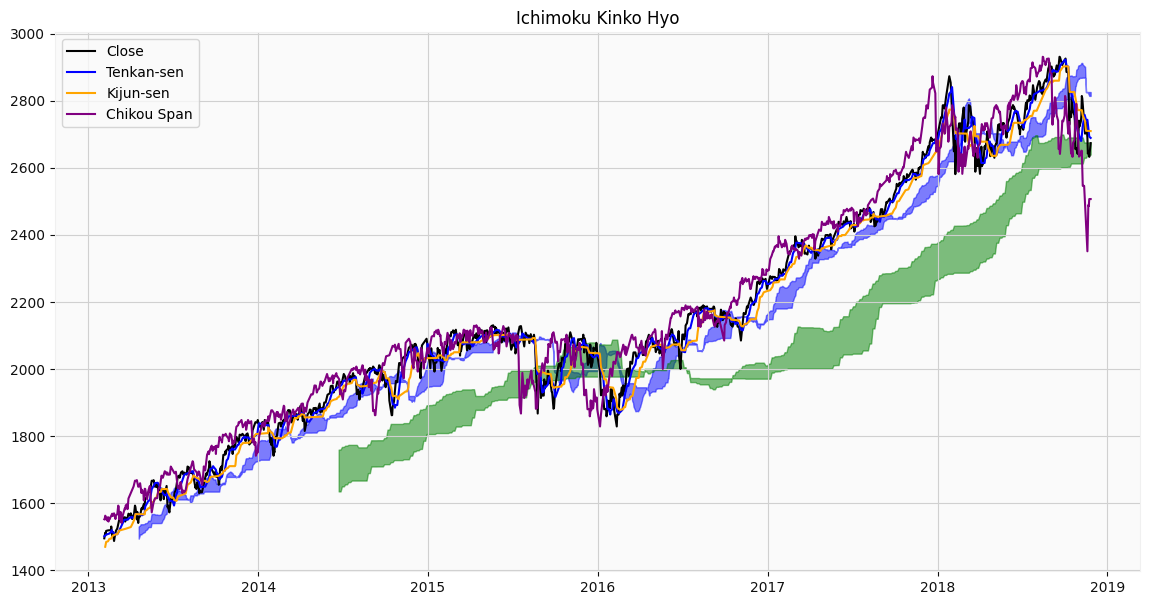

In [163]:
plt.figure(figsize=(14,7))
# S&p500 Close 
plt.plot(New_data_train.index, New_data_train.Close, label='Close', color='black')
# S&p500 Tenkan
plt.plot(New_data_train.index, New_data_train.Tenkan, label='Tenkan-sen', color='blue')
# S&p500 Kijun
plt.plot(New_data_train.index, New_data_train.Kijun, label='Kijun-sen', color='orange')
# S&p500 Chikou Span
plt.plot(New_data_train.index, New_data_train.CS, label='Chikou Span', color='purple')


# Fill in the daily Kumo Cloud
plt.fill_between(New_data_train.index, New_data_train.SSA, New_data_train.SSB,color='blue',alpha=0.5)
# Fill in the weekly Kumo Cloud
plt.fill_between(New_data_train.index,New_data_train.SSA_week,New_data_train.SSB_week,color='green',alpha=0.5)

plt.title('Ichimoku Kinko Hyo')
plt.legend()
plt.show()

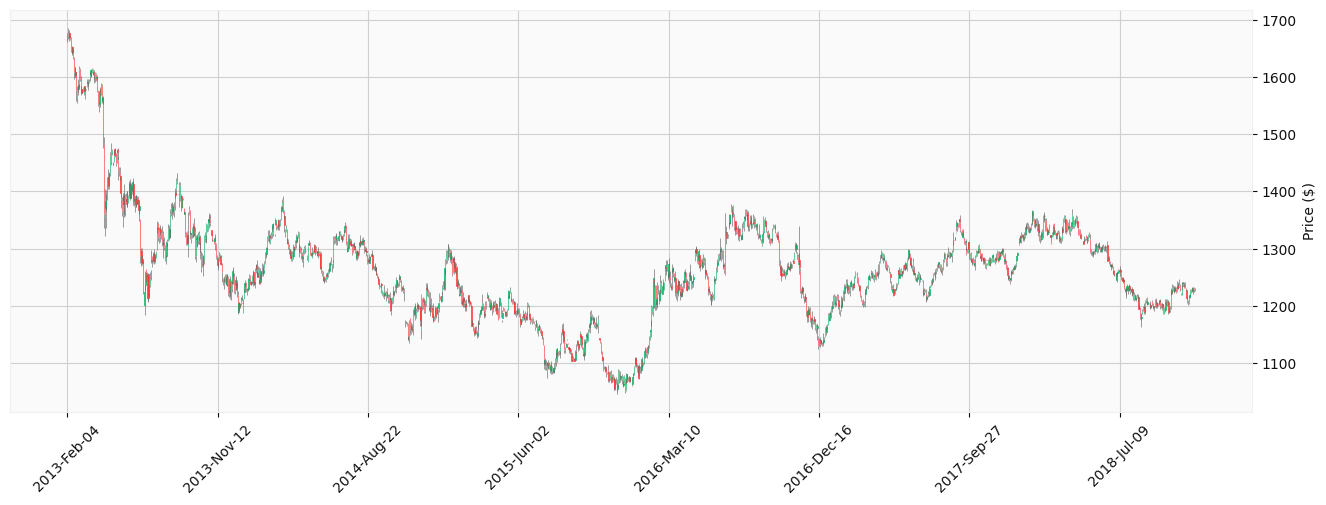

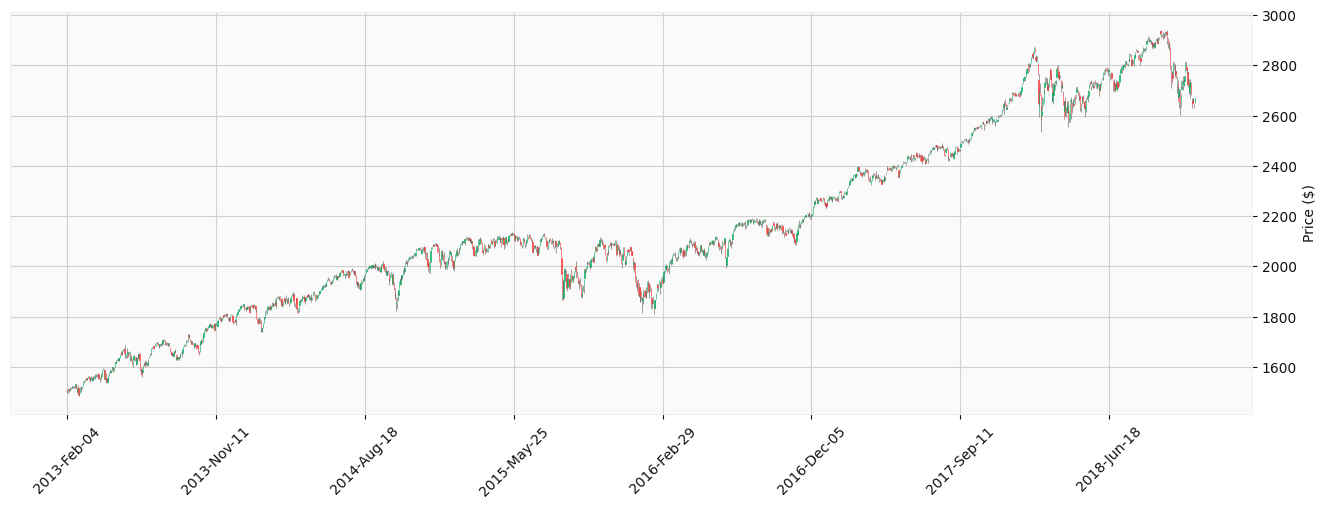

In [164]:
mpf.plot(train_gold.set_index('Date').rename(columns={'Close_gold':'Close'})[['Low','High','Open','Close']], type='candle', style='yahoo',ylabel='Price ($)',figratio=(15, 5))  
mpf.plot(data_train.set_index('Dates'), type='candle', style='yahoo',ylabel='Price ($)',figratio=(15, 5))     

<font color=red><h1> 3. Strategy Design and Implementation </h1></font>

<font color=blue><h3> 3.1 Training phase </h3></font>

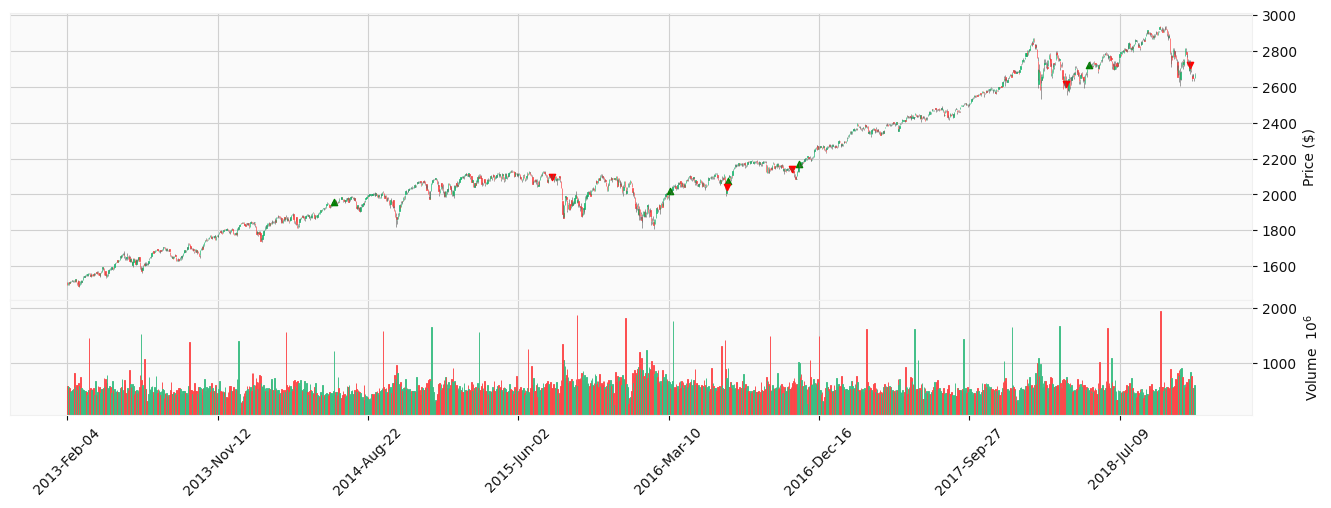

In [ ]:
# Training the trading strategy using the training dataset
XX_axis=New_data_train.index
# Buying signals
Long_open_signals_train=pd.Series(index=XX_axis)
# Closing signals
Long_close_signals_train=pd.Series(index=XX_axis)

position=0

for i in range(26,len(XX_axis)-1):
    ssa=New_data_train.SSA[i]
    ssb=New_data_train.SSB[i]
    close=New_data_train.Close[i]


    ssa_c=New_data_train.SSA[i-26]
    ssb_c=New_data_train.SSB[i-26]
    close_c=New_data_train.Close[i-26]


    open=New_data_train.Open[i+1]

    # Send a buying signal when:
    if (close>max(ssa,ssb)) & (close>max(New_data_train.SSA_week[i],New_data_train.SSB_week[i]))& (New_data_train.Close_gold[i]>min(New_data_train.SSA_week_gold[i],New_data_train.SSB_week_gold[i]))& (New_data_train.High[i]-close<0.2*(close-New_data_train.Low[i]))&(position==0):
        position=1
        # Go long at the open of the next day
        Long_open_signals_train[i+1]=open
    # Close the long position when:
    if ((max(New_data_train.SSA_week[i],New_data_train.SSB_week[i])<close<min(ssa,ssb)) & (close_c<max(ssa_c,ssb_c)) & (close-New_data_train.Low[i]>New_data_train.Open[i]-close)) & (position==1) :
        position=0
        # Close the long position at the open of the next day
        Long_close_signals_train[i+1]=open



Buy_triangles=mpf.make_addplot(Long_open_signals_train,scatter=True,markersize=20,marker='^',color='green')
Sell_triangles=mpf.make_addplot(Long_close_signals_train,scatter=True,markersize=20,marker='v',color='red')
mpf.plot(New_data_train,volume=True, type='candle', style='yahoo', addplot=[Buy_triangles,Sell_triangles],ylabel='Price ($)',figratio=(15, 5))    

<font color=blue><h3> 3.2 Testing phase </h3></font>

In [166]:
# Testing the trading strategy using the testing dataset
XX_axis=New_data_test.index
# Buying signals
Long_open_signals_test=pd.Series(index=XX_axis)
# Closing signals
Long_close_signals_test=pd.Series(index=XX_axis)

position=0

for i in range(26,len(XX_axis)-1):
    ssa=New_data_test.SSA[i]
    ssb=New_data_test.SSB[i]
    close=New_data_test.Close[i]


    ssa_c=New_data_test.SSA[i-26]
    ssb_c=New_data_test.SSB[i-26]
    close_c=New_data_test.Close[i-26]


    open=New_data_test.Open[i+1]
    

    if (close>max(ssa,ssb)) & (close>max(New_data_test.SSA_week[i],New_data_test.SSB_week[i]))& (New_data_test.Close_gold[i]>min(New_data_test.SSA_week_gold[i],New_data_test.SSB_week_gold[i]))& (New_data_test.High[i]-close<0.2*(close-New_data_test.Low[i]))&(position==0):
        position=1
        Long_open_signals_test[i+1]=open
        
    if ((max(New_data_test.SSA_week[i],New_data_test.SSB_week[i])<close<min(ssa,ssb)) & (close_c<max(ssa_c,ssb_c)) & (close-New_data_test.Low[i]>New_data_test.Open[i]-close)) & (position==1) :
        position=0
        Long_close_signals_test[i+1]=open

<font color=blue><h3> 3.3 Results </h3></font>

In [167]:
# Calculate the cumulative returns of the S&P 500 and the Ichimoku strategy

spy_returns_train=(New_data_train.Close.pct_change())
spy_returns_test=(New_data_test.Close.pct_change())

nb_trades_train=len(Long_close_signals_train[Long_close_signals_train.notna()])
nb_trades_test=len(Long_close_signals_test[Long_close_signals_test.notna()])

Por_train=pd.DataFrame({"position":np.zeros(len(New_data_train))},index=New_data_train.index)
Por_test=pd.DataFrame({"position":np.zeros(len(New_data_test))},index=New_data_test.index)

for i,j in zip(Long_open_signals_train[Long_open_signals_train.notna()][:nb_trades_train].index,Long_close_signals_train[Long_close_signals_train.notna()].index):
    Por_train.loc[i:j,'position']=spy_returns_train.loc[i:j]

for i,j in zip(Long_open_signals_test[Long_open_signals_test.notna()][:nb_trades_test].index,Long_close_signals_test[Long_close_signals_test.notna()].index):
    Por_test.loc[i:j,'position']=spy_returns_test.loc[i:j]


spy_returns_train.loc[:Long_open_signals_train[Long_open_signals_train.notna()][:nb_trades_train].index[0]]=0
spy_returns_train.loc[Long_close_signals_train[Long_close_signals_train.notna()].index[-1]:]=0

spy_returns_test.loc[:Long_open_signals_test[Long_open_signals_test.notna()][:nb_trades_test].index[0]]=0
spy_returns_test.loc[Long_close_signals_test[Long_close_signals_test.notna()].index[-1]:]=0

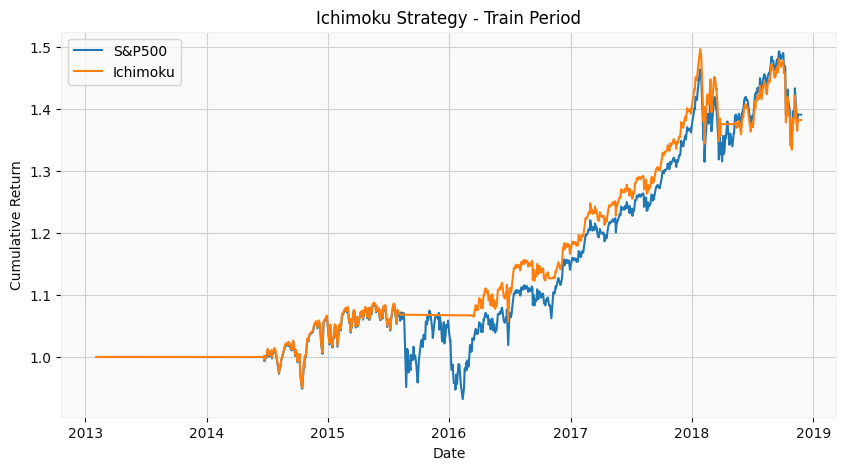

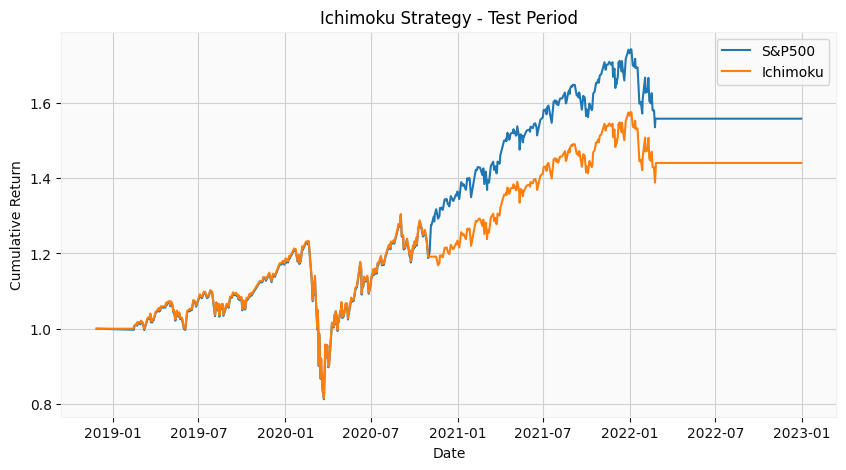

In [168]:
plt.figure(figsize=(10,5))
plt.plot((1 + spy_returns_train).cumprod())
plt.plot((1 + Por_train).cumprod())
plt.legend(['S&P500', 'Ichimoku'])
plt.title('Ichimoku Strategy - Train Period')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()


plt.figure(figsize=(10,5))
plt.plot((1 + spy_returns_test).cumprod())
plt.plot((1 + Por_test).cumprod())
plt.legend(['S&P500', 'Ichimoku'])
plt.title('Ichimoku Strategy - Test Period')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()